# 00_setup.ipynb

## Project Setup and Data Integrity Scan

**Goal**: Install all required dependencies, detect hardware, define project paths, and perform a comprehensive scan of the dataset to ensure data integrity before processing.

### What This Notebook Does:
1. Install core ML libraries (PyTorch, Ultralytics, OpenCV, etc.)
2. Install diffusion stack (SDXL, ControlNet) and SAM for synthetic generation
3. Detect GPU and print CUDA details
4. Define `PROJECT_ROOT` and verify `./data` existence
5. Scan data folder: print tree summary, image/label counts
6. Auto-detect annotation format (YOLO txt, COCO json, VOC xml, **KITTI**)
7. Validate image-label matching for train/val splits
8. Visualize 5 random samples with ground truth bounding boxes
9. Report any dataset issues (missing files, empty labels, invalid bboxes)

In [1]:
# ============================================================================
# CONFIGURATION CELL - Modify these settings as needed
# ============================================================================

import os
import sys

# --- Core Settings ---
SEED = 42
IMG_SIZE = 640
BATCH = 16
MODEL = 'yolov8l'  # Options: yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
EPOCHS = 100

# --- Path Settings ---
MOUNT_DRIVE = True  # Set to True if running on Colab and need data from Drive
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Autonomous_Driving_Project"  # Colab Drive path

# --- Environment Detection ---
try:
    from google.colab import drive
    IN_COLAB = True
    if MOUNT_DRIVE:
        drive.mount('/content/drive')
        if not os.path.exists(DRIVE_PROJECT_PATH):
            os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)
            print(f"Created drive project folder: {DRIVE_PROJECT_PATH}")
        os.chdir(DRIVE_PROJECT_PATH)
        print(f"✅ Colab: Working directory changed to {DRIVE_PROJECT_PATH}")
except ImportError:
    IN_COLAB = False
    # If Local, ensure we're at project root
    if os.path.basename(os.getcwd()) == "notebooks":
        os.chdir("..")
    print(f"✅ Local: Working directory is {os.getcwd()}")

# Define project paths
PROJECT_ROOT = "."
DATA_DIR = "data"
IMAGES_DIR = os.path.join(DATA_DIR, "images")
LABELS_DIR = os.path.join(DATA_DIR, "labels")

# Output directories
OUTPUT_DIRS = [
    "data/processed",
    "data/synthetic/images",
    "data/synthetic/labels",
    "data/splits",
    "results/metrics",
    "results/figures",
    "results/predictions"
]

# Verify Data Directory
if not os.path.exists(DATA_DIR):
    print(f"❌ WARNING: {DATA_DIR} not found in {os.getcwd()}.")
    print("   Please ensure your dataset is placed in ./data/")
else:
    print(f"✅ Data directory detected: {DATA_DIR}")

Mounted at /content/drive
✅ Colab: Working directory changed to /content/drive/MyDrive/Autonomous_Driving_Project
✅ Data directory detected: data


## 1. Install Dependencies

Installing all required packages:
- **Core ML**: PyTorch, Ultralytics (YOLO), OpenCV, scikit-learn
- **Diffusion Stack**: diffusers, transformers, accelerate, xformers
- **SAM**: Segment Anything Model for object masking
- **Extras**: CLIP for realism scoring, scikit-image for SSIM

In [2]:
# Core ML dependencies
!pip install -q ultralytics torch torchvision opencv-python-headless pillow matplotlib pandas tqdm scikit-learn

# Image processing and metrics
!pip install -q scikit-image

# Diffusion stack for SDXL + ControlNet
!pip install -q diffusers transformers accelerate safetensors xformers

# Segment Anything Model (SAM)
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

# CLIP for realism scoring
!pip install -q open_clip_torch

# COCO tools (optional, installed if COCO format detected)
try:
    import pycocotools
    print("✅ pycocotools already installed")
except ImportError:
    !pip install -q pycocotools

print("\n✅ All dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39

## 2. Hardware and Environment Check

In [3]:
import torch
import numpy as np
import random

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("=" * 60)
print("ENVIRONMENT INFORMATION")
print("=" * 60)
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Random Seed: {SEED}")
print()

# GPU Detection
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 GPU DETECTED")
    print(f"   Device Name: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")
    print(f"   cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   Compute Capability: {torch.cuda.get_device_capability(0)}")
else:
    DEVICE = torch.device("cpu")
    print("⚠️  WARNING: No GPU detected. Processing will be significantly slower.")
    print("   Consider using Google Colab with GPU runtime.")

print(f"\n✅ Using device: {DEVICE}")

# Create output directories
print("\n" + "=" * 60)
print("CREATING OUTPUT DIRECTORIES")
print("=" * 60)
for d in OUTPUT_DIRS:
    os.makedirs(d, exist_ok=True)
    print(f"  📁 {d}")
print("\n✅ All output directories created.")

ENVIRONMENT INFORMATION
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.9.0+cu128
Random Seed: 42

🚀 GPU DETECTED
   Device Name: NVIDIA L4
   CUDA Version: 12.8
   cuDNN Version: 91002
   GPU Memory: 23.8 GB
   Compute Capability: (8, 9)

✅ Using device: cuda

CREATING OUTPUT DIRECTORIES
  📁 data/processed
  📁 data/synthetic/images
  📁 data/synthetic/labels
  📁 data/splits
  📁 results/metrics
  📁 results/figures
  📁 results/predictions

✅ All output directories created.


## 3. Data Scan and Validation

This section performs a comprehensive scan of the `data` folder to:
1. Print folder structure and file counts
2. Auto-detect annotation format (YOLO, COCO, VOC, or **KITTI**)
3. Validate image-label pairing
4. Check for common issues

In [4]:
import glob
import json
from pathlib import Path
from collections import defaultdict

def scan_directory_tree(path, max_depth=3, prefix=""):
    """Print a visual tree of the directory structure."""
    if not os.path.exists(path):
        print(f"❌ Path not found: {path}")
        return

    entries = sorted(os.listdir(path))
    dirs = [e for e in entries if os.path.isdir(os.path.join(path, e)) and e != 'ex']
    files = [e for e in entries if os.path.isfile(os.path.join(path, e))]

    # Count files by extension
    ext_counts = defaultdict(int)
    for f in files:
        ext = Path(f).suffix.lower()
        ext_counts[ext] += 1

    # Print current directory
    dir_name = os.path.basename(path) or path
    file_summary = ", ".join([f"{count} {ext}" for ext, count in sorted(ext_counts.items())]) if ext_counts else "empty"
    print(f"{prefix}📁 {dir_name}/ ({file_summary})")

    # Recursively print subdirectories
    if max_depth > 0:
        for i, d in enumerate(dirs):
            is_last = (i == len(dirs) - 1)
            new_prefix = prefix + ("    " if is_last else "│   ")
            scan_directory_tree(os.path.join(path, d), max_depth - 1, new_prefix)

print("=" * 60)
print("DATA DIRECTORY STRUCTURE")
print("=" * 60)
scan_directory_tree(DATA_DIR, max_depth=3)

DATA DIRECTORY STRUCTURE
📁 data/ (empty)
│   📁 images/ (empty)
│   │   📁 train/ (7481 .png)
│       📁 val/ (7518 .png)
│   📁 labels/ (7481 .txt)
│   📁 processed/ (empty)
│   📁 raw/ (empty)
│       📁 kitti/ (empty)
│           📁 training/ (empty)
│   📁 splits/ (empty)
    📁 synthetic/ (empty)
    │   📁 images/ (empty)
        📁 labels/ (empty)


In [5]:
def detect_annotation_format(labels_dir):
    """
    Detect the annotation format by sampling label files.
    Returns: 'KITTI', 'YOLO', 'COCO', 'VOC', or 'UNKNOWN'
    """
    # Check for JSON (COCO format)
    json_files = glob.glob(os.path.join(labels_dir, "**/*.json"), recursive=True)
    if json_files:
        return 'COCO'

    # Check for XML (VOC format)
    xml_files = glob.glob(os.path.join(labels_dir, "**/*.xml"), recursive=True)
    if xml_files:
        return 'VOC'

    # Check TXT files for YOLO vs KITTI
    txt_files = glob.glob(os.path.join(labels_dir, "**/*.txt"), recursive=True)
    if not txt_files:
        return 'UNKNOWN'

    # Sample a few files to determine format
    yolo_votes = 0
    kitti_votes = 0

    for txt_file in txt_files[:20]:  # Sample first 20 files
        try:
            with open(txt_file, 'r') as f:
                first_line = f.readline().strip()
                if not first_line:
                    continue

                parts = first_line.split()
                if len(parts) >= 15:  # KITTI has 15+ columns
                    # Check if first column is a class name (string)
                    try:
                        float(parts[0])  # YOLO: first column is numeric class ID
                        yolo_votes += 1
                    except ValueError:
                        kitti_votes += 1  # KITTI: first column is class name string
                elif len(parts) == 5:  # Standard YOLO format
                    try:
                        vals = [float(x) for x in parts]
                        # YOLO normalized coordinates are typically 0-1
                        if all(0 <= v <= 1 for v in vals[1:]):
                            yolo_votes += 1
                    except ValueError:
                        pass
        except Exception:
            continue

    if kitti_votes > yolo_votes:
        return 'KITTI'
    elif yolo_votes > 0:
        return 'YOLO'
    else:
        return 'UNKNOWN'

# Detect annotation format
print("\n" + "=" * 60)
print("ANNOTATION FORMAT DETECTION")
print("=" * 60)

ANNOTATION_FORMAT = detect_annotation_format(LABELS_DIR)
print(f"\n✅ Detected Annotation Format: {ANNOTATION_FORMAT}")

if ANNOTATION_FORMAT == 'KITTI':
    print("\nKITTI Format Details:")
    print("  Column 0: Class name (Car, Pedestrian, Cyclist, etc.)")
    print("  Column 1: Truncation (0.0-1.0)")
    print("  Column 2: Occlusion (0=visible, 3=occluded)")
    print("  Column 3: Alpha (observation angle)")
    print("  Columns 4-7: Bounding box (x_left, y_top, x_right, y_bottom) in pixels")
    print("  Columns 8-14: 3D information (dimensions, location, rotation)")


ANNOTATION FORMAT DETECTION

✅ Detected Annotation Format: KITTI

KITTI Format Details:
  Column 0: Class name (Car, Pedestrian, Cyclist, etc.)
  Column 1: Truncation (0.0-1.0)
  Column 2: Occlusion (0=visible, 3=occluded)
  Column 3: Alpha (observation angle)
  Columns 4-7: Bounding box (x_left, y_top, x_right, y_bottom) in pixels
  Columns 8-14: 3D information (dimensions, location, rotation)


In [6]:
def find_image_label_pairs(images_dir, labels_dir):
    """
    Find matching image-label pairs for KITTI-style dataset.

    Expected structure:
    - images/train/*.png
    - images/val/*.png
    - labels/*.txt (shared folder, or labels/train, labels/val)
    """
    pairs = {'train': [], 'val': []}
    issues = []

    for split in ['train', 'val']:
        split_img_dir = os.path.join(images_dir, split)

        if not os.path.exists(split_img_dir):
            issues.append({'split': split, 'issue': f'Image directory not found: {split_img_dir}'})
            continue

        # Get all images
        image_files = glob.glob(os.path.join(split_img_dir, "*.[pP][nN][gG]")) + \
                      glob.glob(os.path.join(split_img_dir, "*.[jJ][pP][gG]")) + \
                      glob.glob(os.path.join(split_img_dir, "*.[jJ][pP][eE][gG]"))

        for img_path in sorted(image_files):
            base_name = os.path.splitext(os.path.basename(img_path))[0]

            # Try different label path patterns
            label_candidates = [
                os.path.join(labels_dir, f"{base_name}.txt"),  # Shared labels folder
                os.path.join(labels_dir, split, f"{base_name}.txt"),  # Split-specific
                os.path.join(images_dir.replace('images', 'labels'), split, f"{base_name}.txt"),
            ]

            label_path = None
            for candidate in label_candidates:
                if os.path.exists(candidate):
                    label_path = candidate
                    break

            if label_path:
                pairs[split].append({
                    'image': img_path,
                    'label': label_path,
                    'base_name': base_name,
                    'split': split
                })
            else:
                issues.append({
                    'file': img_path,
                    'split': split,
                    'issue': 'Missing label file'
                })

    return pairs, issues

print("\n" + "=" * 60)
print("IMAGE-LABEL PAIRING VALIDATION")
print("=" * 60)

pairs, pairing_issues = find_image_label_pairs(IMAGES_DIR, LABELS_DIR)

print(f"\n📊 Pairing Results:")
print(f"   Train pairs: {len(pairs['train'])}")
print(f"   Val pairs: {len(pairs['val'])}")
print(f"   Total pairs: {len(pairs['train']) + len(pairs['val'])}")
print(f"   Issues found: {len(pairing_issues)}")

if pairing_issues:
    print(f"\n⚠️  Sample issues (first 5):")
    for issue in pairing_issues[:5]:
        print(f"   - {issue}")


IMAGE-LABEL PAIRING VALIDATION

📊 Pairing Results:
   Train pairs: 7481
   Val pairs: 7481
   Total pairs: 14962
   Issues found: 37

⚠️  Sample issues (first 5):
   - {'file': 'data/images/val/007481.png', 'split': 'val', 'issue': 'Missing label file'}
   - {'file': 'data/images/val/007482.png', 'split': 'val', 'issue': 'Missing label file'}
   - {'file': 'data/images/val/007483.png', 'split': 'val', 'issue': 'Missing label file'}
   - {'file': 'data/images/val/007484.png', 'split': 'val', 'issue': 'Missing label file'}
   - {'file': 'data/images/val/007485.png', 'split': 'val', 'issue': 'Missing label file'}


In [7]:
def parse_kitti_label(label_path):
    """
    Parse KITTI format label file.

    Returns list of dicts with keys:
    - class_name: str
    - truncation: float
    - occlusion: int
    - alpha: float
    - bbox: (x1, y1, x2, y2) in pixels
    - dimensions: (h, w, l) in meters
    - location: (x, y, z) in camera coords
    - rotation_y: float
    """
    objects = []

    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 15:
                    continue

                obj = {
                    'class_name': parts[0],
                    'truncation': float(parts[1]),
                    'occlusion': int(float(parts[2])),
                    'alpha': float(parts[3]),
                    'bbox': (
                        float(parts[4]),  # x_left
                        float(parts[5]),  # y_top
                        float(parts[6]),  # x_right
                        float(parts[7])   # y_bottom
                    ),
                    'dimensions': (
                        float(parts[8]),   # height
                        float(parts[9]),   # width
                        float(parts[10])   # length
                    ),
                    'location': (
                        float(parts[11]),  # x
                        float(parts[12]),  # y
                        float(parts[13])   # z
                    ),
                    'rotation_y': float(parts[14])
                }
                objects.append(obj)
    except Exception as e:
        print(f"Error parsing {label_path}: {e}")

    return objects

def validate_labels(pairs_dict, annotation_format):
    """
    Validate label files for common issues.
    """
    validation_issues = []
    class_counts = defaultdict(int)
    total_objects = 0
    empty_labels = 0

    all_pairs = pairs_dict['train'] + pairs_dict['val']

    for pair in all_pairs:
        if annotation_format == 'KITTI':
            objects = parse_kitti_label(pair['label'])

            if not objects:
                empty_labels += 1
                continue

            for obj in objects:
                class_counts[obj['class_name']] += 1
                total_objects += 1

                # Validate bounding box
                x1, y1, x2, y2 = obj['bbox']
                if x2 <= x1 or y2 <= y1:
                    validation_issues.append({
                        'file': pair['label'],
                        'issue': f'Invalid bbox: ({x1}, {y1}, {x2}, {y2})'
                    })
                if x1 < 0 or y1 < 0:
                    validation_issues.append({
                        'file': pair['label'],
                        'issue': f'Negative coordinates: ({x1}, {y1})'
                    })

    return {
        'class_counts': dict(class_counts),
        'total_objects': total_objects,
        'empty_labels': empty_labels,
        'validation_issues': validation_issues
    }

print("\n" + "=" * 60)
print("LABEL VALIDATION")
print("=" * 60)

validation_results = validate_labels(pairs, ANNOTATION_FORMAT)

print(f"\n📊 Dataset Statistics:")
print(f"   Total objects: {validation_results['total_objects']:,}")
print(f"   Images with no labels: {validation_results['empty_labels']}")
print(f"   Validation issues: {len(validation_results['validation_issues'])}")

print(f"\n📈 Class Distribution:")
for cls, count in sorted(validation_results['class_counts'].items(), key=lambda x: -x[1]):
    pct = 100 * count / validation_results['total_objects'] if validation_results['total_objects'] > 0 else 0
    print(f"   {cls:15s}: {count:6,} ({pct:5.1f}%)")

# Filter out DontCare for relevant classes
RELEVANT_CLASSES = [cls for cls in validation_results['class_counts'].keys() if cls != 'DontCare']
print(f"\n✅ Relevant classes (excluding DontCare): {RELEVANT_CLASSES}")


LABEL VALIDATION

📊 Dataset Statistics:
   Total objects: 103,730
   Images with no labels: 0
   Validation issues: 0

📈 Class Distribution:
   Car            : 57,484 ( 55.4%)
   DontCare       : 22,590 ( 21.8%)
   Pedestrian     :  8,974 (  8.7%)
   Van            :  5,828 (  5.6%)
   Cyclist        :  3,254 (  3.1%)
   Truck          :  2,188 (  2.1%)
   Misc           :  1,946 (  1.9%)
   Tram           :  1,022 (  1.0%)
   Person_sitting :    444 (  0.4%)

✅ Relevant classes (excluding DontCare): ['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting']


## 4. Visualize Sample Images with Ground Truth Boxes


SAMPLE VISUALIZATION (5 Random Images with GT Boxes)


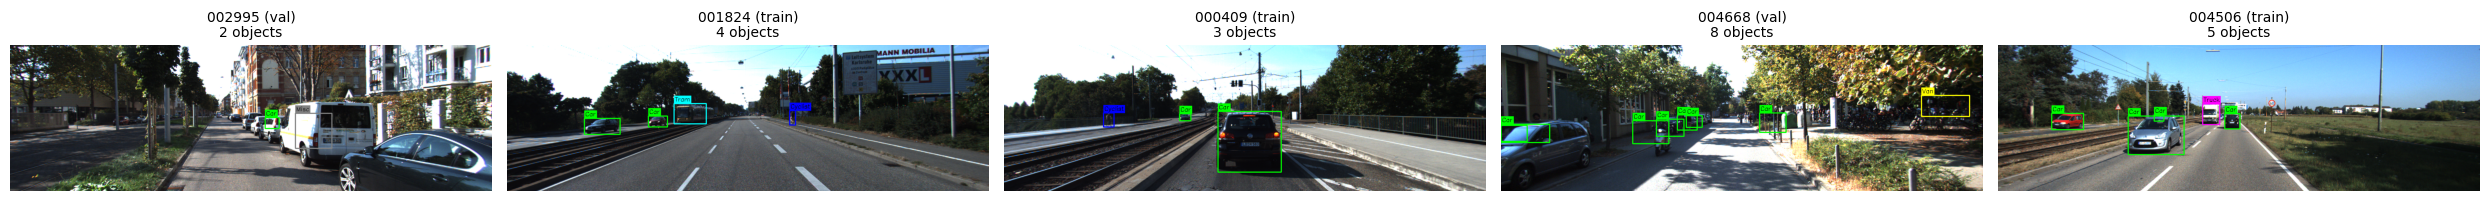


✅ Sample visualization saved to results/figures/sample_gt_visualization.png


In [8]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Color map for different classes
CLASS_COLORS = {
    'Car': (0, 255, 0),         # Green
    'Pedestrian': (255, 0, 0),   # Red
    'Cyclist': (0, 0, 255),      # Blue
    'Van': (255, 255, 0),        # Yellow
    'Truck': (255, 0, 255),      # Magenta
    'Person_sitting': (255, 128, 0),  # Orange
    'Tram': (0, 255, 255),       # Cyan
    'Misc': (128, 128, 128),     # Gray
    'DontCare': (100, 100, 100), # Dark Gray
}

def draw_kitti_boxes(img_path, label_path, show_dontcare=False):
    """
    Draw bounding boxes on an image for KITTI format annotations.
    """
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return np.zeros((375, 1242, 3), dtype=np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    objects = parse_kitti_label(label_path)

    for obj in objects:
        if obj['class_name'] == 'DontCare' and not show_dontcare:
            continue

        x1, y1, x2, y2 = [int(v) for v in obj['bbox']]
        color = CLASS_COLORS.get(obj['class_name'], (255, 255, 255))

        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # Draw label background
        label = f"{obj['class_name']}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (x1, y1 - 20), (x1 + w + 4, y1), color, -1)

        # Draw label text
        cv2.putText(img, label, (x1 + 2, y1 - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    return img

# Visualize 5 random samples
print("\n" + "=" * 60)
print("SAMPLE VISUALIZATION (5 Random Images with GT Boxes)")
print("=" * 60)

all_pairs = pairs['train'] + pairs['val']

if len(all_pairs) > 0:
    # Select 5 random samples
    random.seed(SEED)
    sample_pairs = random.sample(all_pairs, min(5, len(all_pairs)))

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for i, pair in enumerate(sample_pairs):
        img_viz = draw_kitti_boxes(pair['image'], pair['label'])

        ax = axes[i] if len(sample_pairs) > 1 else axes
        ax.imshow(img_viz)
        ax.axis('off')

        # Count objects in this image
        objs = parse_kitti_label(pair['label'])
        obj_count = len([o for o in objs if o['class_name'] != 'DontCare'])
        ax.set_title(f"{pair['base_name']} ({pair['split']})\n{obj_count} objects", fontsize=10)

    plt.tight_layout()
    plt.savefig('results/figures/sample_gt_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Sample visualization saved to results/figures/sample_gt_visualization.png")
else:
    print("❌ No valid image-label pairs found to visualize.")

## 5. Save Scan Report

In [9]:
# Compile comprehensive scan report
scan_report = {
    'project_root': os.path.abspath(PROJECT_ROOT),
    'annotation_format': ANNOTATION_FORMAT,
    'device': str(DEVICE),
    'seed': SEED,
    'dataset_stats': {
        'train_images': len(pairs['train']),
        'val_images': len(pairs['val']),
        'total_images': len(pairs['train']) + len(pairs['val']),
        'total_objects': validation_results['total_objects'],
        'empty_labels': validation_results['empty_labels']
    },
    'class_distribution': validation_results['class_counts'],
    'relevant_classes': RELEVANT_CLASSES,
    'issues': {
        'pairing_issues': len(pairing_issues),
        'validation_issues': len(validation_results['validation_issues']),
        'sample_pairing_issues': pairing_issues[:10],
        'sample_validation_issues': validation_results['validation_issues'][:10]
    },
    'paths': {
        'images_dir': IMAGES_DIR,
        'labels_dir': LABELS_DIR,
        'train_image_sample': pairs['train'][0]['image'] if pairs['train'] else None,
        'train_label_sample': pairs['train'][0]['label'] if pairs['train'] else None
    }
}

# Save report
report_path = 'results/metrics/scan_report.json'
with open(report_path, 'w') as f:
    json.dump(scan_report, f, indent=2)

print("\n" + "=" * 60)
print("SCAN REPORT SUMMARY")
print("=" * 60)
print(f"\n📄 Report saved to: {report_path}")
print(f"\n✅ Annotation Format: {ANNOTATION_FORMAT}")
print(f"✅ Total Images: {scan_report['dataset_stats']['total_images']:,}")
print(f"   - Train: {scan_report['dataset_stats']['train_images']:,}")
print(f"   - Val: {scan_report['dataset_stats']['val_images']:,}")
print(f"✅ Total Objects: {scan_report['dataset_stats']['total_objects']:,}")
print(f"✅ Relevant Classes: {', '.join(RELEVANT_CLASSES)}")

if len(pairing_issues) > 0 or len(validation_results['validation_issues']) > 0:
    print(f"\n⚠️  Issues Found:")
    print(f"   - Missing labels: {len(pairing_issues)}")
    print(f"   - Invalid bboxes: {len(validation_results['validation_issues'])}")
else:
    print(f"\n✅ No issues found - dataset is ready for processing!")


SCAN REPORT SUMMARY

📄 Report saved to: results/metrics/scan_report.json

✅ Annotation Format: KITTI
✅ Total Images: 14,962
   - Train: 7,481
   - Val: 7,481
✅ Total Objects: 103,730
✅ Relevant Classes: Pedestrian, Truck, Car, Cyclist, Misc, Van, Tram, Person_sitting

⚠️  Issues Found:
   - Missing labels: 37
   - Invalid bboxes: 0


In [10]:
# Export pairs for use in other notebooks
import pickle

# Save pairs to pickle for easy loading in other notebooks
pairs_path = 'results/metrics/image_label_pairs.pkl'
with open(pairs_path, 'wb') as f:
    pickle.dump(pairs, f)

print(f"✅ Image-label pairs saved to: {pairs_path}")
print(f"   Load in other notebooks with:")
print(f"   >>> import pickle")
print(f"   >>> with open('{pairs_path}', 'rb') as f:")
print(f"   >>>     pairs = pickle.load(f)")

✅ Image-label pairs saved to: results/metrics/image_label_pairs.pkl
   Load in other notebooks with:
   >>> import pickle
   >>> with open('results/metrics/image_label_pairs.pkl', 'rb') as f:
   >>>     pairs = pickle.load(f)


## Summary

This notebook has:
1. ✅ Installed all required dependencies (core ML, diffusion stack, SAM, CLIP)
2. ✅ Detected GPU and printed CUDA details
3. ✅ Defined `PROJECT_ROOT` and verified `./data` existence
4. ✅ Scanned data folder and printed structure summary
5. ✅ Auto-detected annotation format (KITTI)
6. ✅ Validated image-label pairing for train/val splits
7. ✅ Visualized 5 random samples with GT bounding boxes
8. ✅ Reported dataset issues (if any)
9. ✅ Saved comprehensive scan report to `results/metrics/scan_report.json`

**Next Steps:**
- Run `01_eda.ipynb` for detailed exploratory data analysis
- Run `02_synthetic_generation.ipynb` to generate weather variants
- Run `03_train_eval_compare.ipynb` for model training and evaluation